In [135]:
from time import time
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import scipy.io

In [147]:
def wta(y, k, ltd=-1.0, ltp=1.0):
    winners = np.argpartition(y, -k, axis=1)[:, -k:]
    idx = np.repeat(range(y.shape[0]), winners.shape[1]), winners.reshape(-1)
    yw = np.zeros(y.shape)
    yw[idx] = y[idx]
    yw_sign = ltd * np.ones(y.shape)
    yw_sign[idx] = ltp
    return yw, yw_sign

def wta2(y, k, kl, ltd=-1.0, ltp=1.0):
    sorted_idx = np.argsort(y, axis=1)
    winners_idx = np.repeat(range(y.shape[0]), k), sorted_idx[:, -k:].reshape(-1)
    losers_idx = np.repeat(range(y.shape[0]), kl), sorted_idx[:, -(kl+k):-k].reshape(-1)
    
    yw = np.zeros(y.shape)
    yw[winners_idx] = y[winners_idx]

    yw_sign = np.zeros(y.shape)
    yw_sign[winners_idx] = ltp
    yw_sign[losers_idx] = ltd
    return yw, yw_sign

def whiten(X, fudge=1E-18):
    Xcov = np.dot(X.T,X)
    d, V = np.linalg.eigh(Xcov)
    D = np.diag(1. / np.sqrt(d+fudge))
    W = np.dot(np.dot(V, D), V.T)
    X_white = np.dot(X, W)
    return X_white, W

def plot_weights(W):
    input_d = int(np.sqrt(W.shape[0]))
    hidden_d = int(np.sqrt(W.shape[1]))

    W_plot = np.zeros((input_d * hidden_d, input_d * hidden_d))
    i = 0
    for y in range(hidden_d):
        for x in range(hidden_d):
            W_plot[
                y*input_d:(y+1)*input_d,
                x*input_d:(x+1)*input_d
            ] = W[:, i].reshape(input_d, input_d)
            i += 1
    return shm(W_plot)

def shm(*matrices, **kwargs):
    plt.figure(1, figsize=(25,10))
    for m_id, matrix in enumerate(matrices):
        plt.subplot(len(matrices), 1, m_id+1)
        plt.imshow(np.squeeze(matrix).T, cmap='gray', origin='lower')
        plt.colorbar()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()
    
def to_binary(x):
    return np.where(x > 0, 1.0, 0.0).astype(np.uint8)
        
def relu(x):
    return np.where(x > 0, x, 0.0)

def norm(w, factor=1.0):
    for i in range(w.shape[1]):
        w[:, i] = factor * w[:, i] / np.sqrt(np.sum(np.square(w[:,i])))

def weights_inner_product(W, p):
    return np.asarray([np.linalg.norm(W[:, ni], ord=p) for ni in range(W.shape[1])])

def shl(*vector, **kwargs):
    plt.figure(1, figsize=(15,10))
    labels = kwargs.get("labels", [])
    for id, v in enumerate(vector):
        if len(labels) > 0:
            plt.plot(np.squeeze(v), label=labels[id])
        else:
            plt.plot(np.squeeze(v))

    if len(labels) > 0:
        plt.legend()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()

def patchefy(W, patch_size):
    orig_size = int(np.sqrt(W.shape[0]))

    Wo = W.reshape((orig_size, orig_size, W.shape[1]))
    Wc = np.zeros(Wo.shape)

    for ni in range(W.shape[1]):
        xp0 = random.randrange(0, orig_size-patch_size[0])
        yp0 = random.randrange(0, orig_size-patch_size[1])

        xp1 = xp0+patch_size[0]
        yp1 = yp0+patch_size[1]

        Wc[xp0:xp1, yp0:yp1, ni] = Wo[xp0:xp1, yp0:yp1, ni]

    return Wc.reshape(W.shape)
  

In [3]:
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics, callbacks
import tensorflow as tf

def train_mlp(
    X, 
    Y, 
    Xt, 
    Yt, 
    hidden_layer_size=None, 
    epochs=300,
    init_learning_rate=0.02,
    verbose=0
):    
    def scheduler(epoch):
        return init_learning_rate * (1.0 - epoch / epochs)
    
    if hidden_layer_size is not None:
        model = Sequential([
            layers.Dense(hidden_layer_size, activation='relu'), 
            layers.Dense(Y.shape[1])
        ])
    else:
        model = Sequential([
            layers.Dense(Y.shape[1])
        ])

    model.compile(
        optimizer=optimizers.Adam(), #SGD(init_learning_rate),
        loss=tf.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    model.fit(
        X, Y, 
        epochs=epochs,
        validation_data=(Xt, Yt),
        batch_size=200,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=10),
            callbacks.LearningRateScheduler(scheduler)
        ],
        verbose=verbose,
        shuffle=True
    )    
    return max(model.history.history["val_accuracy"])

In [4]:
def top_k_ids(D, k):
    Di = np.argpartition(D, k, axis=1)
    if k > 0:
        Di_top = Di[:, :k]
    else:
        Di_top = Di[:, k:]
    Dv_top = np.take_along_axis(D, Di_top, axis=1)
    return np.take_along_axis(Di_top, np.argsort(Dv_top, axis=1), axis=1)

def query_coded(xc, yc, k):
    D = np.asarray([np.sum(ycv ^ xc, axis=1) for ycv in yc])
    return top_k_ids(D, k)

def overlaps(X, Y):
    assert X.shape == Y.shape
    return np.asarray([len(np.intersect1d(x, y)) for x, y in zip(X, Y)])

def quality(proposed, gt, number_of_neighbors):
    return np.mean(overlaps(proposed, gt) / number_of_neighbors)

def quality_coded(xc, yc, gt, k):
    return quality(query_coded(xc, yc, k), gt, k)

In [5]:
mat = scipy.io.loadmat('mnist_all.mat')

def read_mnist(mat, label, num_classes=10, subsample=None):
    X = np.zeros((0, 784))
    Y = np.zeros((0, num_classes))
    for i in range(num_classes):
        data = mat[label + str(i)]
        if subsample is not None:
            data = data[:subsample]

        X = np.concatenate((X, data), axis=0)

        Yi = np.zeros((data.shape[0], num_classes))
        Yi[:, i] = 1.0
        Y = np.concatenate((Y, Yi), axis=0)

    X = X / 255.0
    return X.astype(np.float32), Y.astype(np.float32)

X, Y = read_mnist(mat, "train", 10, 500)
Xt, Yt = read_mnist(mat, "test", 10, 500)
# Xp = X - np.mean(X, axis=0)
# Xpt = Xt - np.mean(X, axis=0)
# Xp, W_whiten = whiten(Xp, fudge=1e-05)
# Xpt = np.dot(Xpt, W_whiten)

In [6]:
train_mlp(X, Y, Xt, Yt, init_learning_rate=0.02, hidden_layer_size=None, verbose=0)

0.8818

In [341]:
np.random.seed(0)
theta = 0.0
# a = 1.0
a = 1.0
b = 1.0
epochs = 100
learning_rate = 0.0001
init_learning_rate = 0.0001
batch_size = 200
num_hidden = 49
number_of_train_batches = X.shape[0] // batch_size
number_of_test_batches = Xt.shape[0] // batch_size
dt = 0.1
num_init_epochs = 20
k_win = 10

alpha_res = 5.0
alpha_norm = 0.001
W_max = 1.0
W_min = 0.0

tau_avg = 50.0

W = np.random.normal(0.0, 1.0, (X.shape[1], num_hidden))
W_sign = np.sign(W)
# W = patchefy(W, (7, 7))
# Wzero = np.where(W == 0)
# norm(W)


R = np.zeros((num_hidden, num_hidden))
# R = 0.01 * np.abs(np.random.normal(0.0, 1.0, (num_hidden, num_hidden)))
np.fill_diagonal(R, 0)

W0 = W.copy()
R0 = R.copy()

In [ ]:
y_stat = np.zeros((epochs, num_hidden))
converge_stat = np.zeros((epochs, 2))

y_avg = np.zeros((num_hidden,))
y_avg_stat = np.zeros((epochs, num_hidden))

Xa = np.zeros((X.shape[0], num_hidden), dtype=np.float32)
Xta = np.zeros((Xt.shape[0], num_hidden), dtype=np.float32)

dW_h = np.zeros((epochs, number_of_train_batches,) + W.shape, dtype=np.float32)
y_h = np.zeros((epochs, number_of_train_batches,) + (batch_size, num_hidden), dtype=np.float32)
yd_h = np.zeros((epochs, number_of_train_batches,) + (batch_size, num_hidden), dtype=np.float32)
W_h = np.zeros((epochs, number_of_train_batches,) + W.shape, dtype=np.float32)

for epoch in range(epochs):
    dW_norm = 0.0
    dR_norm = 0.0
    
#     learning_rate = init_learning_rate * (1-epoch / epochs)
    
    permute_ids = np.random.permutation(X.shape[0])
    X = X[permute_ids, :]
    Y = Y[permute_ids, :]

    t0 = time()
    for i in range(number_of_train_batches):
        x = X[i*batch_size:(i+1)*batch_size,:]
        
#         y = np.zeros((batch_size, num_hidden))
#         u = np.zeros((batch_size, num_hidden))
#         for _ in range(5):
#             du = np.dot(x, W) - np.dot(y, R)
#             u += dt * du
#             y = a * relu(u)
            
        yr = a * relu(np.dot(x, W))
        
        y, y_sign = wta2(yr, 5, 5, ltd=-0.01)

        # statistics

        y_avg_cur = np.mean(y, 0)
        
        y_avg = (1.0 - 1.0 / tau_avg) * y_avg + (1.0 / tau_avg) * y_avg_cur
        y_avg_stat[epoch] += y_avg

        # learning
        
        if epoch < num_init_epochs:
            continue

#         y_deriv = y
#         y_deriv = y * (y - y_avg)
        y_deriv = yr * y_sign
        

        # hard constraints logic
#         W_res = np.sum(np.abs(W), 0, keepdims=True)
    
#         dR = np.dot(y.T, y)        
        dW = np.dot(x.T, y_deriv) # - np.sum(y_deriv * y, 0, keepdims=True) * W
#         dW = np.dot(x.T, y_deriv) - W_sign * alpha_norm * (W_res - alpha_res)

        
        dW_norm += np.linalg.norm(dW)
#         dR_norm += np.linalg.norm(dR)
#         dW_norm += np.mean(W_res)

#         dW[Wzero] = 0.0
        W += learning_rate * dW / np.amax(np.absolute(dW))
        
#         R += learning_rate * dR
#         np.fill_diagonal(R, 0)

#         W_abs = np.abs(W)
#         W = W_sign * np.where(W_abs > W_max, W_max, np.where(W_abs < W_min, W_min, W_abs))
        
        Xa[i*batch_size:(i+1)*batch_size,:] = y.copy()
        dW_h[epoch, i] = dW.copy()
        y_h[epoch, i] = y.copy()
        yd_h[epoch, i] = y_deriv.copy()
        W_h[epoch, i] = W.copy()
        
    t1 = time()
#     norm(W)
    
    y_avg_stat[epoch] /= number_of_train_batches

    converge_stat[epoch, 0] = dW_norm / number_of_train_batches
    converge_stat[epoch, 1] = dR_norm / number_of_train_batches

    if epoch > num_init_epochs:
        for i in range(number_of_test_batches):
            xt = Xt[i*batch_size:(i+1)*batch_size,:]

#             yt = np.zeros((batch_size, num_hidden))
#             ut = np.zeros((batch_size, num_hidden))
#             for _ in range(5):
#                 dut = np.dot(x, W) - np.dot(y, R)
#                 ut += dt * dut
#                 yt = a * relu(ut)

            yt = a * relu(np.dot(xt, W))
            yt, _ = wta(yt, k_win)

            Xta[i*batch_size:(i+1)*batch_size,:] = yt.copy()

#     if epoch == num_init_epochs-1:
#         break
        
    if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
        # q = train_mlp(Xa, Y, Xta, Yt, init_learning_rate=0.02, hidden_layer_size=None, verbose=0)
        q = np.nan
        print(
            "Epoch {} "
            "|dW| = {:.3f} "
            "ex(W) = {:.3f},{:.3f} "
            "|W| = {:.3f} "
            "|dR| = {:.3f} "
            "<y> = {:.3f} q = {:.3f} took {:.3f}s".format(
            epoch, 
            converge_stat[epoch, 0],
            np.min(W),
            np.max(W),
            weights_inner_product(W, 2)[0],
            converge_stat[epoch, 1],
            np.mean(y_stat[epoch]),
            q,
            t1-t0
            #np.mean(weights_inner_product(W, 2))
        ))    

Epoch 0 |dW| = 0.000 ex(W) = -4.660,3.832 |W| = 27.800 |dR| = 0.000 <y> = 0.000 q = nan took 0.026s
Epoch 10 |dW| = 0.000 ex(W) = -4.660,3.832 |W| = 27.800 |dR| = 0.000 <y> = 0.000 q = nan took 0.036s
Epoch 20 |dW| = 1570296.709 ex(W) = -4.660,3.832 |W| = 27.800 |dR| = 0.000 <y> = 0.000 q = nan took 0.049s


In [ ]:
shm(yd_h[20,0], yd_h[-1,0])

In [ ]:
plot_weights(np.mean(np.mean(dW_h[20:30], axis=0), axis=0))

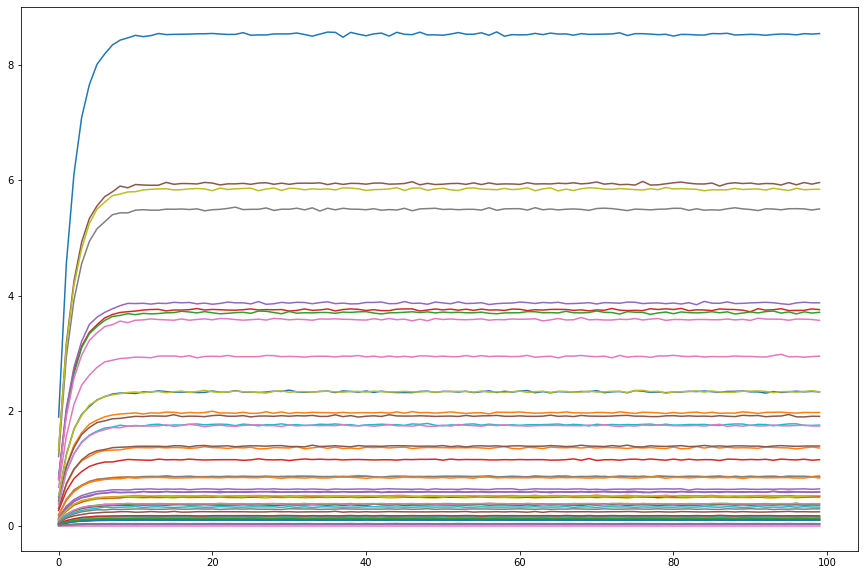

In [340]:
shl(y_avg_stat)

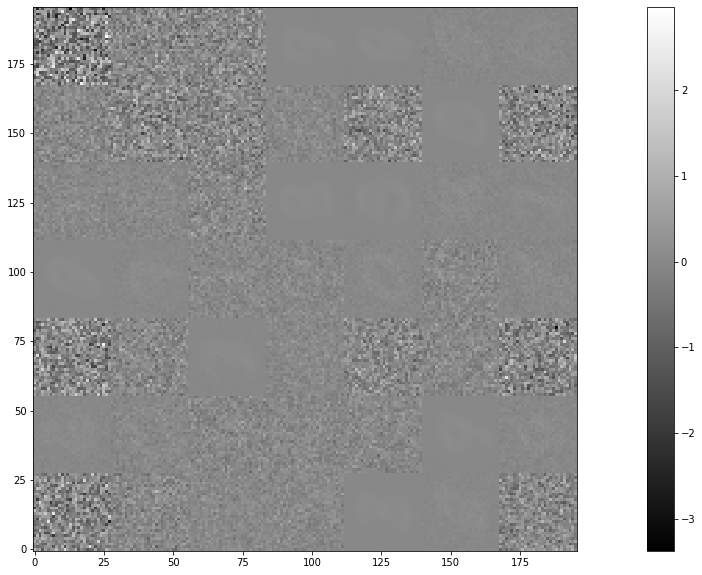

In [335]:
plot_weights(W)

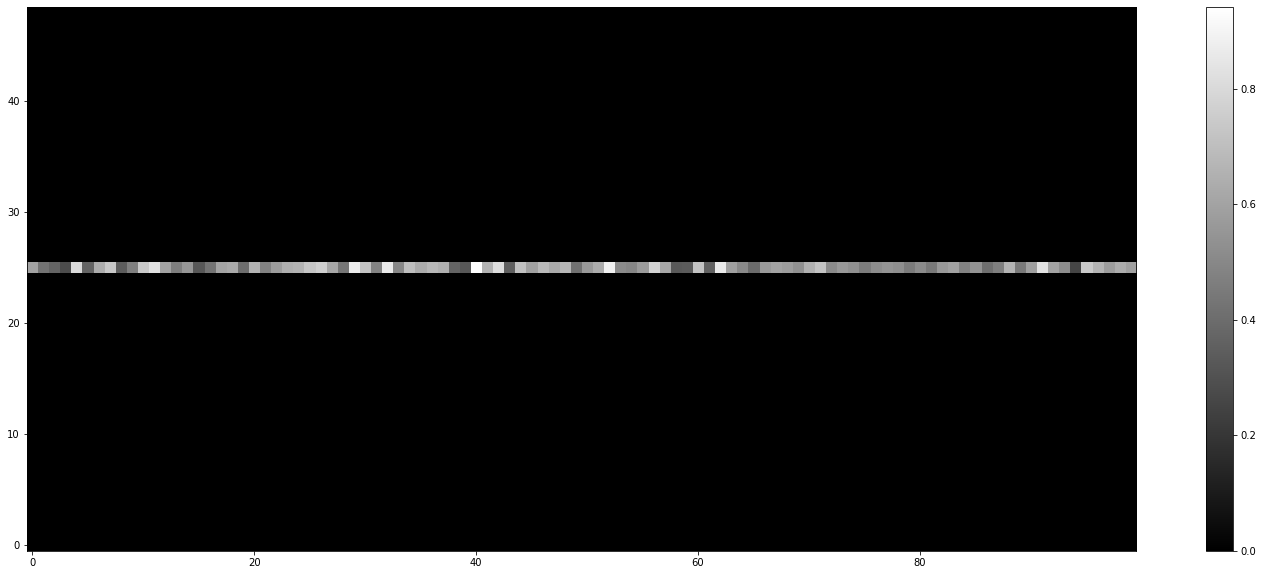

In [186]:
shm(Xa[:100])

In [129]:
train_mlp(Xa, Y, Xta, Yt, init_learning_rate=0.02, hidden_layer_size=None, verbose=0)

0.1008